In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import circmean
import fly_analysis as fa
from tqdm import tqdm

In [2]:
def sg_smooth(df):
    """
    Applies Savitzky-Golay filter to smooth specified columns in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the columns to be smoothed.

    Returns:
    pandas.DataFrame: The DataFrame with smoothed columns.

    The function applies the Savitzky-Golay filter with a window length of 21 and a polynomial order of 3
    to the columns 'x', 'y', 'z', 'xvel', 'yvel', and 'zvel' in the input DataFrame.
    """
    columns = ["x", "y", "z", "xvel", "yvel", "zvel"]
    df[columns] = df[columns].apply(lambda x: savgol_filter(x, 21, 3))
    return df

def get_angular_velocity(xvel, yvel, dt=0.01):
    """
    Calculate the angular velocity from x and y velocity components.

    Parameters:
    xvel (array-like): The x-component of the velocity.
    yvel (array-like): The y-component of the velocity.
    dt (float, optional): The time step between velocity measurements. Default is 0.01.

    Returns:
    numpy.ndarray: The angular velocity calculated from the input velocities.
    """
    theta = np.arctan2(yvel, xvel)
    theta_unwrap = np.unwrap(theta)
    return np.gradient(theta_unwrap, dt)

def get_linear_velocity(xvel, yvel):
    """
    Calculate the linear velocity given the x and y components of velocity.

    Parameters:
    xvel (float): The velocity component in the x direction.
    yvel (float): The velocity component in the y direction.

    Returns:
    float: The linear velocity calculated using the Pythagorean theorem.
    """
    return np.sqrt(xvel**2 + yvel**2)


def get_saccades(angular_velocity, linear_velocity, **kwargs):
    """
    Detects saccades in the given angular velocity data.

    Parameters:
    angular_velocity (array-like): The angular velocity data to analyze.
    **kwargs: Additional keyword arguments for peak detection.
        - height (float, optional): Minimum height of peaks. Default is np.deg2rad(300).
        - distance (int, optional): Minimum distance between peaks. Default is 20.

    Returns:
    array: Indices of the detected saccades.
    """
    saccades = find_peaks(
        np.abs(angular_velocity),
        height=kwargs.get("height", np.deg2rad(300)),
        distance=kwargs.get("distance", 20),
    )[0]

    saccades = saccades[linear_velocity[saccades] > kwargs.get("min_speed", 0.1)]
    return saccades


def plot_mean_and_std(arr, ax=None, take_abs=True, units = "frames", label=None):
    """
    Plots the mean and standard deviation of the given array.

    Parameters:
    arr (numpy.ndarray): The input array to compute mean and standard deviation.
    ax (matplotlib.axes.Axes, optional): The axes on which to plot. If None, a new figure and axes are created.
    take_abs (bool, optional): If True, takes the absolute value of the array before computing mean and std. Default is True.
    label (str, optional): The label for the plot. Default is None.

    Returns:
    matplotlib.axes.Axes: The axes with the plot.
    """
    if ax is None:
        _, ax = plt.subplots()

    if take_abs:
        arr = np.abs(arr)

    mean = np.nanmean(arr, axis=0)
    std = np.nanstd(arr, axis=0)
    
    X = np.arange(len(mean))
    if units == "ms":
        X *= 0.01
        
    ax.plot(X, mean, label=label)
    ax.fill_between(
        X,
        mean - std,
        mean + std,
        alpha=0.2,
    )
    return ax


def plot_histogram(arr, ax=None, label=None):
    """
    Plots a histogram of the given array with a density estimate.

    Parameters:
    arr (array-like): The input data array to plot.
    ax (matplotlib.axes.Axes, optional): The axes on which to plot the histogram. 
                                         If None, a new figure and axes are created.
    label (str, optional): The label for the histogram.

    Returns:
    matplotlib.axes.Axes: The axes with the plotted histogram.
    """
    if ax is None:
        _, ax = plt.subplots()

    sns.histplot(
        arr,
        ax=ax,
        bins=36,
        binrange=(-np.pi, np.pi),
        stat="density",
        kde=True,
    )
    return ax

In [3]:
def calculate_inverted_signed_angle(v1, v2):
    # Calculate the signed angle between two vectors
    angle = np.arctan2(np.cross(v1, v2), np.dot(v1, v2))

    # Invert the angle
    if angle >= 0:
        inverted_angle = np.pi - angle
    else:
        inverted_angle = -np.pi - angle

    return inverted_angle  # This will be in radians, in the range [-π, π]


def get_heading_difference_for_trajectory(xyz, midpoint=65, n_around=10):
    if np.shape(xyz)[1] == 3:
        xyz = xyz[:, :2]

    vector_before = xyz[midpoint - n_around] - xyz[midpoint]
    vector_after = xyz[midpoint + n_around] - xyz[midpoint]

    return calculate_inverted_signed_angle(vector_before, vector_after)

def extract_saccade_angvel(angular_velocity, idx):
    return angular_velocity[idx - 50 : idx + 100]

def extract_saccade_linvel(linear_velocity, idx):
    return linear_velocity[idx - 50 : idx + 100]

def flatten_nested(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten_nested(item))
        else:
            result.append(item)
    return result

def get_all_saccade_data(df, stim, **kwargs):
    spont_angvels = []
    stim_angvels = []
    spont_linvels = []
    stim_linvels = []
    spont_heading_diffs = []
    stim_heading_diffs = []

    n_before = kwargs.get("n_before", 50)
    n_after = kwargs.get("n_after", 100)
    delay = kwargs.get("delay", 15)

    for _, row in tqdm(stim.iterrows(), total=len(stim)):
        obj_id = row["obj_id"]
        exp_num = row["exp_num"]
        frame = row["frame"]

        grp = df[(df["obj_id"] == obj_id) & (df["exp_num"] == exp_num)]

        if len(grp) < kwargs.get("min_grp_length", 150):
            continue

        try:
            stim_idx = np.where(grp["frame"] == frame)[0][0]
        except IndexError:
            continue

        if stim_idx - n_before < 0 or stim_idx + n_after > len(grp):
            continue

        grp = sg_smooth(grp)

        angular_velocity = get_angular_velocity(
            grp["xvel"].to_numpy(), grp["yvel"].to_numpy()
        )
        linear_velocity = get_linear_velocity(
            grp["xvel"].to_numpy(), grp["yvel"].to_numpy()
        )

        # get all saccades
        saccade_indices = get_saccades(angular_velocity, linear_velocity, **kwargs)

        for saccade in saccade_indices:
            if stim_idx < saccade < stim_idx+n_after:
                continue
            elif saccade-n_before-delay < 0 or saccade+n_before-delay > len(grp):
                continue
            else:
                angvel = angular_velocity[saccade - n_before-delay : saccade + n_after-delay]
                linvel = linear_velocity[saccade - n_before-delay : saccade + n_after-delay]
                heading_diff = get_heading_difference_for_trajectory(grp[["x", "y"]].to_numpy(), saccade, 10)

                spont_angvels.append(angvel)
                spont_linvels.append(linvel)
                spont_heading_diffs.append(heading_diff)
                
        # get only stim-related saccades
        index_slice = slice(stim_idx - n_before, stim_idx + n_after)
        stim_angvels.append(angular_velocity[index_slice])
        stim_linvels.append(linear_velocity[index_slice])
        stim_heading_diffs.append(get_heading_difference_for_trajectory(grp[["x", "y"]].to_numpy(), stim_idx, 10))

    spont_angvels = np.array(flatten_nested(spont_angvels))
    spont_linvels = np.array(flatten_nested(spont_linvels))
    spont_heading_diffs = np.array(flatten_nested(spont_heading_diffs))

    # convert other lists to numpy
    stim_angvels = np.array(stim_angvels)
    stim_linvels = np.array(stim_linvels)
    stim_heading_diffs = np.array(stim_heading_diffs)

    out_dict = {
        "spont_angvels": spont_angvels,
        "stim_angvels": stim_angvels,
        "spont_linvels": spont_linvels,
        "stim_linvels": stim_linvels,
        "spont_heading_diffs": spont_heading_diffs,
        "stim_heading_diffs": stim_heading_diffs,
    }
    return out_dict


In [ ]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"

# Process j53xu68 files
print("Processing j53xu68 files")
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data = fa.braidz.read_multiple_braidz(j53xu68_files, root_folder)

# # Process g29xu68 files
# print("Processing g29xu68 files")
# g29xu68_files = ["20230512_144203.braidz", "20230203_145747.braidz"]
# g29_data = fa.braidz.read_multiple_braidz(g29xu68_files, root_folder)

# # Process emptyxu68 files
# print("Processing emptyxu68 files")
# emptyxu68_files = [
#     "20231020_150051.braidz",
#     "20230530_115028.braidz",
# ]
# empty_data = fa.braidz.read_multiple_braidz(emptyxu68_files, root_folder)

Processing j53xu68 files
Reading /home/buchsbaum/mnt/md0/Experiments/20230321_162524.braidz using pyarrow


In [33]:
j53_results = get_all_saccade_data(j53_data["df"], j53_data["stim"])

  0%|          | 0/531 [00:00<?, ?it/s]

100%|██████████| 531/531 [01:35<00:00,  5.55it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4754,) + inhomogeneous part.

In [11]:
g29_results = get_all_saccade_data(g29_data["df"], g29_data["stim"])

100%|██████████| 1574/1574 [02:59<00:00,  8.77it/s]


<Axes: >

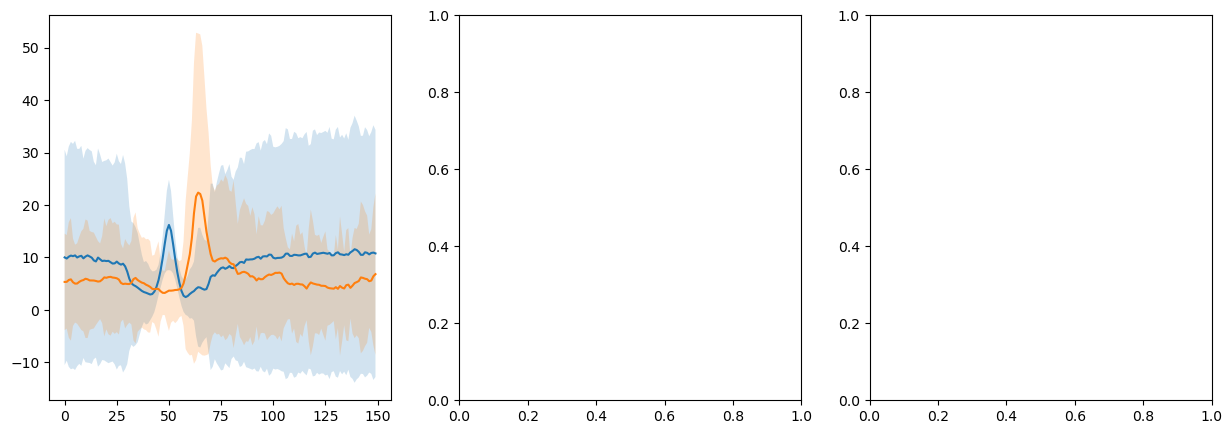

In [24]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
plot_mean_and_std(j53_results["spont_angvels"], label="Spont", ax=axs[0])
plot_mean_and_std(j53_results["stim_angvels"], label="Stim", ax=axs[0])
#plot_mean_and_std(g29_results["angular_velocity"], label="g29", ax=axs[0])
